In [1]:
# Core imports
import numpy as np
import math
import matplotlib.pyplot as plt

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# Your package
import optpricer as op
from optpricer.processes import local_vol_paths, heston_paths

# Reproducibility
rng = np.random.default_rng(42)

# Matplotlib defaults (keep it simple)
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True


In [2]:
def forward_price(S0, r, q, T):
    """Forward price F(0,T) under continuous rates/yield."""
    return S0 * math.exp((r - q) * T)

def synthetic_iv(K, T, S0=100.0, r=0.03, q=0.0):
    """
    A toy, arbitrage-friendly-ish IV model:
      σ_imp(k, T) = (a0 + a1*sqrt(T)) * (1 + b1*|k| + b2*k)
    where k = ln(K/F). Choose small slopes to keep convexity mostly sane.
    """
    F = forward_price(S0, r, q, T)
    k = np.log(np.asarray(K) / F)
    a0, a1 = 0.16, 0.06     # term structure (base + term premium)
    b1, b2 = 0.35, -0.15    # smile curvature & skew (smirk)
    base = a0 + a1 * np.sqrt(T)
    smile = (1.0 + b1 * np.abs(k) + b2 * k)
    sigma = np.maximum(1e-4, base * smile)
    return sigma

def meshgrid_strikes_tenors(S0=100.0):
    """Build strike and tenor grids centered around ATM forward."""
    Ts = np.array([0.1, 0.25, 0.5, 1.0, 2.0])         # in years
    Ks = np.linspace(60, 140, 33)                     # strikes
    return Ks, Ts

def bs_price_surface(S0, r, q, Ks, Ts, iv_fn):
    """Compute price, implied-vol, and total-variance surfaces on (K,T) grid."""
    IV = np.zeros((len(Ts), len(Ks)))
    PRICE = np.zeros_like(IV)
    W = np.zeros_like(IV)  # total variance = sigma^2 * T
    for i, T in enumerate(Ts):
        for j, K in enumerate(Ks):
            sig = float(iv_fn(K, T, S0=S0, r=r, q=q))  # synthetic smile
            IV[i, j] = sig
            W[i, j] = sig * sig * T
            spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=sig, q=q)
            PRICE[i, j] = op.bs_price(spec, op.CALL)  # call surface
    return PRICE, IV, W


In [3]:
S0, r, q = 100.0, 0.03, 0.0
Ks, Ts = meshgrid_strikes_tenors(S0=S0)

PRICE, IV, W = bs_price_surface(S0, r, q, Ks, Ts, synthetic_iv)

print("Surfaces computed:")
print("PRICE shape:", PRICE.shape, "IV shape:", IV.shape, "W shape:", W.shape)


Surfaces computed:
PRICE shape: (5, 33) IV shape: (5, 33) W shape: (5, 33)


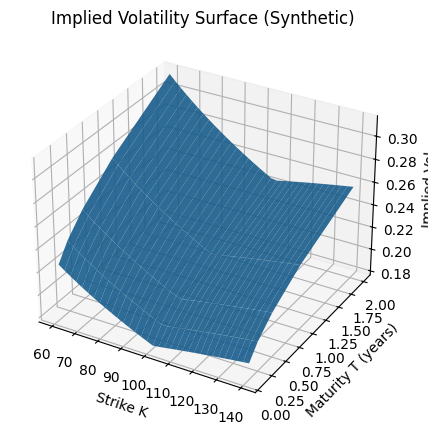

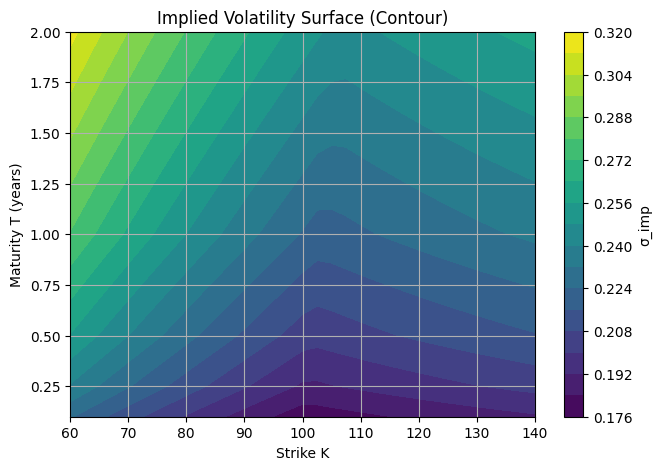

In [4]:
# 3D surface for IV(K,T)
Kmesh, Tmesh = np.meshgrid(Ks, Ts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, IV, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Implied Vol")
ax.set_title("Implied Volatility Surface (Synthetic)")
plt.show()

# Contour view (often easier to read)
plt.figure()
cs = plt.contourf(Kmesh, Tmesh, IV, levels=16)
plt.xlabel("Strike K"); plt.ylabel("Maturity T (years)")
plt.title("Implied Volatility Surface (Contour)")
plt.colorbar(cs, label="σ_imp")
plt.show()


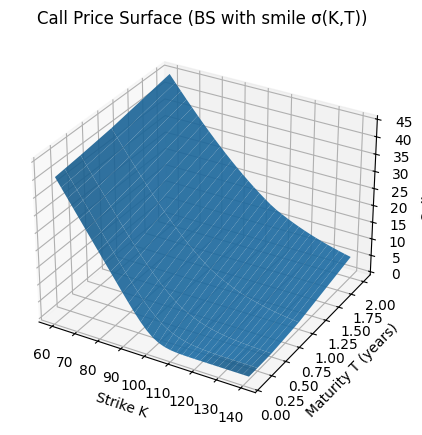

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, PRICE, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Call Price")
ax.set_title("Call Price Surface (BS with smile σ(K,T))")
plt.show()


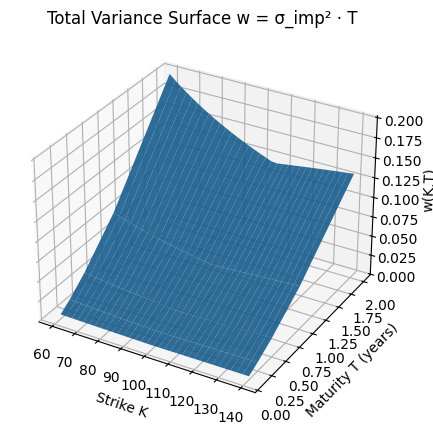

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, W, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("w(K,T)")
ax.set_title("Total Variance Surface w = σ_imp² · T")
plt.show()


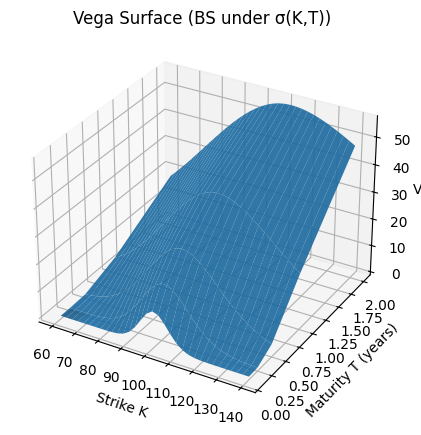

In [7]:
VEGA = np.zeros_like(IV)
for i, T in enumerate(Ts):
    for j, K in enumerate(Ks):
        spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=IV[i, j], q=q)
        g = op.bs_greeks(spec, op.CALL)
        VEGA[i, j] = g["vega"]  # dPrice / dSigma (sigma in absolute units)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, VEGA, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("Vega")
ax.set_title("Vega Surface (BS under σ(K,T))")
plt.show()


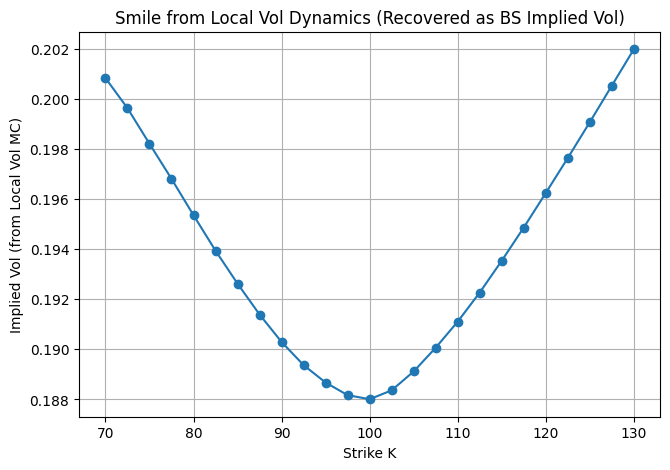

In [8]:
# A toy local-vol function that increases away from ATM (around S=100).
def sigma_loc_toy(S_vec, t):
    base, slope = 0.18, 0.0015
    return base + slope * np.abs(S_vec - 100.0)

# Price a 1Y call across strikes under Local Vol via MC, then recover IV by root-finding
T_mc = 1.0
n_steps, n_paths = 252, 80_000

S_paths = local_vol_paths(S0=S0, r=r, q=q, T=T_mc, n_steps=n_steps, n_paths=n_paths,
                          sigma_loc=sigma_loc_toy, seed=123)
ST = S_paths[-1]
disc = math.exp(-r * T_mc)

K_grid = np.linspace(70, 130, 25)
prices_lv = []
iv_lv = []
for K in K_grid:
    payoff = np.maximum(ST - K, 0.0)
    price = disc * payoff.mean()
    prices_lv.append(price)
    # Invert to implied vol in BS with the SAME (S0, r, q, T)
    spec = op.OptionSpec(S0=S0, K=K, T=T_mc, r=r, sigma=0.2, q=q)
    iv = op.implied_vol(spec, target_price=price, kind=op.CALL)
    iv_lv.append(iv)

prices_lv = np.array(prices_lv)
iv_lv = np.array(iv_lv)

plt.figure()
plt.plot(K_grid, iv_lv, marker="o")
plt.xlabel("Strike K"); plt.ylabel("Implied Vol (from Local Vol MC)")
plt.title("Smile from Local Vol Dynamics (Recovered as BS Implied Vol)")
plt.show()


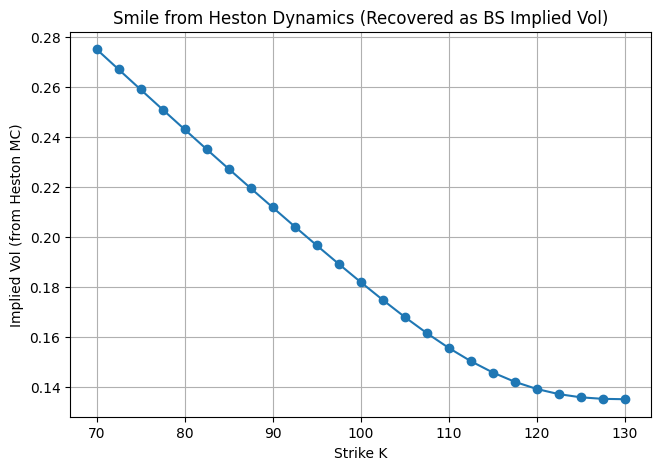

In [9]:
# Heston parameters (choose something that produces a left-skewed smile)
v0, kappa, theta, xi, rho = 0.04, 1.5, 0.04, 0.6, -0.7
T_mc = 1.0
n_steps, n_paths = 252, 100_000

S_paths = heston_paths(S0=S0, r=r, q=q, v0=v0, kappa=kappa, theta=theta, xi=xi, rho=rho,
                       T=T_mc, n_steps=n_steps, n_paths=n_paths, seed=321)
ST = S_paths[-1]
disc = math.exp(-r * T_mc)

K_grid = np.linspace(70, 130, 25)
prices_heston = []
iv_heston = []
for K in K_grid:
    payoff = np.maximum(ST - K, 0.0)
    price = disc * payoff.mean()
    prices_heston.append(price)
    spec = op.OptionSpec(S0=S0, K=K, T=T_mc, r=r, sigma=0.2, q=q)
    iv = op.implied_vol(spec, target_price=price, kind=op.CALL)
    iv_heston.append(iv)

prices_heston = np.array(prices_heston)
iv_heston = np.array(iv_heston)

plt.figure()
plt.plot(K_grid, iv_heston, marker="o")
plt.xlabel("Strike K"); plt.ylabel("Implied Vol (from Heston MC)")
plt.title("Smile from Heston Dynamics (Recovered as BS Implied Vol)")
plt.show()


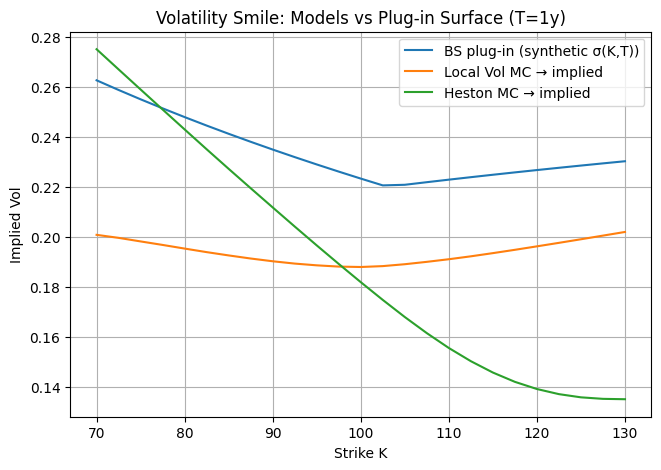

In [10]:
# BS plug-in IV at T=1 from the synthetic surface:
iv_bs = np.array([synthetic_iv(K, 1.0, S0=S0, r=r, q=q) for K in K_grid])

plt.figure()
plt.plot(K_grid, iv_bs, label="BS plug-in (synthetic σ(K,T))")
plt.plot(K_grid, iv_lv, label="Local Vol MC → implied")
plt.plot(K_grid, iv_heston, label="Heston MC → implied")
plt.xlabel("Strike K"); plt.ylabel("Implied Vol")
plt.title("Volatility Smile: Models vs Plug-in Surface (T=1y)")
plt.legend()
plt.show()


Max |IV_rec - IV| over grid: 0.000045


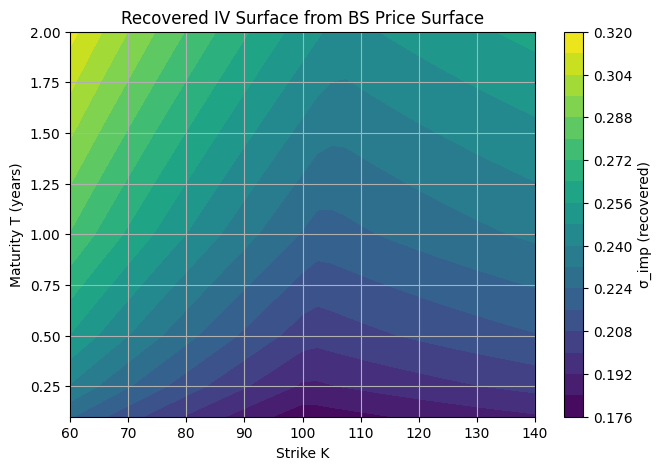

In [11]:
# Recover an IV *surface* from the BS price surface (sanity check round-trip)
IV_rec = np.zeros_like(IV)
for i, T in enumerate(Ts):
    for j, K in enumerate(Ks):
        spec = op.OptionSpec(S0=S0, K=K, T=T, r=r, sigma=0.2, q=q)
        IV_rec[i, j] = op.implied_vol(spec, target_price=PRICE[i, j], kind=op.CALL)

# Quick check: should be very close to the original IV surface
diff = np.max(np.abs(IV_rec - IV))
print(f"Max |IV_rec - IV| over grid: {diff:.6f}")

plt.figure()
cs = plt.contourf(Kmesh, Tmesh, IV_rec, levels=16)
plt.xlabel("Strike K"); plt.ylabel("Maturity T (years)")
plt.title("Recovered IV Surface from BS Price Surface")
plt.colorbar(cs, label="σ_imp (recovered)")
plt.show()
